Processed class 19 → plotted as 2: 1270 cells
Processed class 22 → plotted as 3: 943 cells


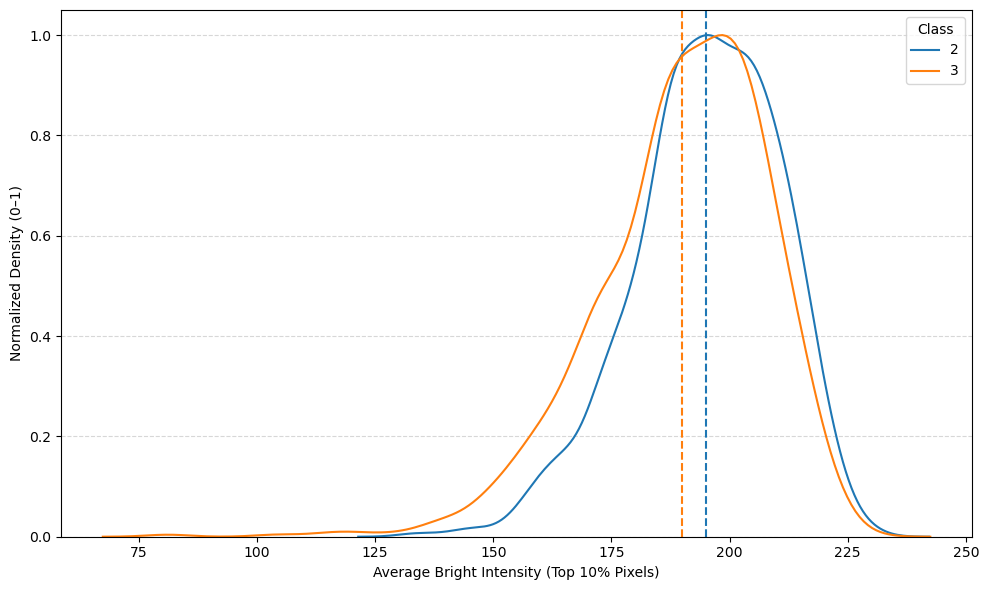

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import seaborn as sns

# Root folder for mH2A1 images
root_dir = r"QUAC_images_protein_0/mH2A1/train" 

# Only keep these folders, and rename with class names
keep_map = { 
    "19": "2",
    "22": "3",
}

bright_intensity = {}

# Loop over subfolders (classes)
for subfolder in sorted(os.listdir(root_dir)):
    if subfolder not in keep_map:
        continue  # skip everything except 19 and 22

    class_path = os.path.join(root_dir, subfolder)
    if not os.path.isdir(class_path):
        continue

    bright_intensity[subfolder] = []

    # Loop over images in subfolder
    for filename in os.listdir(class_path):
        if not filename.lower().endswith(".tiff"):
            continue

        img_path = os.path.join(class_path, filename)
        img = io.imread(img_path).astype(float)

        # Ignore zero pixels (nuclear region)
        nonzero_mask = img > 0
        nonzero_pixels = img[nonzero_mask]

        # Threshold at 90th percentile
        perc_thresh = np.percentile(nonzero_pixels, 90) if len(nonzero_pixels) > 0 else 0

        # Bright mask = top 10% brightest pixels
        bright_mask = (img > perc_thresh) & nonzero_mask

        # Compute average intensity within bright mask
        avg_bright_intensity = np.mean(img[bright_mask]) if np.sum(bright_mask) > 0 else 0

        bright_intensity[subfolder].append(avg_bright_intensity)

    print(f"Processed class {subfolder} → plotted as {keep_map[subfolder]}: {len(bright_intensity[subfolder])} cells")

# -----------------------
# Plot normalized KDE curves
plt.figure(figsize=(10,6))
colors = ["C0", "C1"]

for i, cls in enumerate(sorted(bright_intensity.keys())):
    values = bright_intensity[cls]
    if len(values) == 0:
        continue

    # Get KDE curve
    kde = sns.kdeplot(values, label=keep_map[cls], color=colors[i % len(colors)], fill=False)
    x_data = kde.get_lines()[-1].get_xdata()
    y_data = kde.get_lines()[-1].get_ydata()

    # Normalize y values to 0–1
    y_data_norm = y_data / np.max(y_data)

    # Remove previous line and plot normalized curve
    kde.get_lines()[-1].remove()
    plt.plot(x_data, y_data_norm, color=colors[i % len(colors)], label=keep_map[cls])

    # Plot mean as dashed line
    mean_val = np.mean(values)
    plt.axvline(mean_val, color=colors[i % len(colors)], linestyle='--')

plt.xlabel("Average Bright Intensity (Top 10% Pixels)")
plt.ylabel("Normalized Density (0–1)")
plt.legend(title="Class")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig("mH2A1_puncta_intensity_normalized_2_vs_3.pdf", dpi=300)
plt.show()


In [9]:
test_classes = ["2", "3"]

print("\nPairwise Mann–Whitney U tests (classes 2 vs 3):")
cls1, cls2 = test_classes

# Retrieve the correct raw data from bright_intensity using the original keys
data1 = np.array(bright_intensity["19"])
data2 = np.array(bright_intensity["22"])

stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
print(f"{cls1} vs {cls2}: U={stat:.2f}, p={p:.3e}")



Pairwise Mann–Whitney U tests (classes 2 vs 3):
2 vs 3: U=693010.00, p=2.336e-10
